In [1]:
## Implemtation of Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, by Redford et al (2016)
## Almost exact implementation, with better results
## Use Upsampling instead of ConvTranspose for no checkerboarding but with slightly worse results

In [2]:
# Import packages and modules
import numpy as np
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
os.chdir("/home/agastya/Downloads")
%matplotlib inline

In [3]:
## 1.0 Data Preparation and Preprocessing
# Use transforms.Resize(img_size) to resize the image into (batch_size, 1, img_size, img_size)
def mnist_data():
    compose = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5)) 
         #Normalized to (-1,1) so as to mimic a tanh activation function
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=10, shuffle=True)

URLError: <urlopen error [Errno -2] Name or service not known>

In [ ]:
cuda = True if torch.cuda.is_available() else False

In [ ]:
# Sample random noise froma Gaussian Distribution
def noise(size):
    n = torch.tensor(torch.randn(size, 100), requires_grad=True)
    if torch.cuda.is_available():
        return n.cuda()
    else:
        return n

# Returns an array of 1's for real data
def real_data_targets(size):
    data = torch.tensor(torch.ones(size, 1), requires_grad=False)
    if torch.cuda.is_available():
        return data.cuda()
    else:
        return data

# Returns a array of 0's for fake data
def fake_data_targets(size):
    data = torch.tensor(torch.zeros(size, 1), requires_grad=False)
    if torch.cuda.is_available():
        return data.cuda()
    else:
        return data

In [4]:
# 4 Conv layers followed by a dense layer
# ALWAYS USE LEAKY RELU
# BatchNorm with a momentum of 0.8
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.negative_slope = 0.2
        
        self.layer1 = nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.layer2 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.layer3 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(512)
        self.layer4 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(1024)
        self.layer5 = nn.Linear(1024*4*4, 1)
        
    def forward(self, x):
        
        x = x.view(x.size(0), 1, 64, 64)
        out = F.leaky_relu_(self.layer1(x), self.negative_slope)
        out = self.batch_norm2(self.layer2(out))
        out = F.leaky_relu_(out, self.negative_slope)
        out = self.batch_norm3(self.layer3(out))
        out = F.leaky_relu_(out, self.negative_slope)
        out = self.batch_norm4(self.layer4(out))
        out = F.leaky_relu_(out, self.negative_slope)
        out = F.sigmoid(self.layer5(out.view(-1, 1024*4*4)))
        return out

In [5]:
# RELU gives better results instaed of leaku_relu
# Can use upsampling in place of ConvTranspose in exhange for a slightly worse performance
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.linear = nn.Linear(100, 1024*4*4)
        self.layer1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.layer2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.layer3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.layer4 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False)
        
    def forward(self, x):
        out = self.linear(x)
        out = out.view(x.size(0), 1024, 4, 4)
        out = F.relu_(self.batchnorm1(self.layer1(out)))
        out = F.relu_(self.batchnorm2(self.layer2(out)))
        out = F.relu_(self.batchnorm3(self.layer3(out)))
        out = F.tanh(self.layer4(out))
        return out

In [6]:
# Weights initialization
# gaussian Distribution works the best
# Constant Zeros initialization for Bias
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [7]:
# Binary CrossEntropy Loss
# For discriminator, maximize log(D(x)) + log (1 - D(G(z)))
# For generator, maximize log(D(G(z)))
generator = Generator()
generator.apply(init_weights)
discriminator = Discriminator()
discriminator.apply(init_weights)
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
gen_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
d_steps = 1
num_epochs = 200

In [8]:
def train_disc(optimizer, real_data, fake_data):
    
    optimizer.zero_grad()
    
    # Training on real data
    # real_loss = -log(D(x))
    real_prediction = discriminator(real_data)
    real_loss = criterion(real_prediction, real_data_targets(real_data.size(0)))
    real_loss.backward()
    
    # Training on Generated data
    # fake_loss = -log(1 - D(G(z)))
    # Total_loss = -log(D(x)) - log(1 - D(G(z))
    fake_prediction = discriminator(fake_data)
    fake_loss = criterion(fake_prediction, fake_data_targets(fake_data.size(0)))
    fake_loss.backward()
    

    # Update Gradients
    # Total_loss = -log(D(x)) - log(1 - D(G(z))
    optimizer.step()
    
    return real_loss+fake_loss, real_prediction, fake_prediction

In [9]:
def train_gen(optimizer, fake_data):
    
    optimizer.zero_grad()
    
    # Generator loss is -log(D(G(z)))
    prediction = discriminator(fake_data)
    loss = criterion(prediction, real_data_targets(fake_data.size(0)))
    loss.backward()
    optimizer.step()
    return loss

In [10]:
def train_GAN(num_epochs):
    generator_error = []
    discriminator_error = []
    for epoch in range(num_epochs):
        for batch, (real_data, _) in enumerate(data_loader):
            
            real_data = torch.tensor(real_data.view(real_data.size(0),64*64))
            if torch.cuda.is_available():
                real_data = real_data.cuda()
            fake_data = generator(noise(real_data.size(0))).detach()
            disc_error, disc_real_pred, disc_fake_pred = train_disc(disc_optim, real_data, fake_data)
            
            fake_data = generator(noise(real_data.size(0)))
            gen_error = train_gen(gen_optim, fake_data)
            
            if batch%10==0:
                print("Batch Number: ", batch, " Generator Error: ", 
                      gen_error,"--------", " Discriminator Error: ", disc_error)
                discriminator_error.append(disc_error)
                generator_error.append(gen_error)
                print("Generated ", (epoch+1)*(batch+1))
                f, axes = plt.subplots(1,10, figsize=(20,4))
                for j in range(10):
                    axes[j].imshow(generator(noise(1)).detach().view(64,64).cpu().numpy())
                    plt.axis('off')
                    axes[j].get_xaxis().set_visible(False)
                    axes[j].get_yaxis().set_visible(False)
                plt.show()
                #discriminator_error.append(disc_error)
                #generator_error.append(gen_error)
                #display.clear_output(True)
                #input = noise(1)
                #plt.imshow(input.squeeze(0).view(10,10).numpy())
                #plt.show()
                #plt.imshow(generator(input).detach().view(64,64).numpy())
                #plt.show()
                #plt.plot(generator_error)
                #plt.show()
                #plt.plot(discriminator_error)
                #plt.show()

Batch Number:  0  Generator Error:  tensor(0.9349) --------  Discriminator Error:  tensor(1.5569)
Generated  1


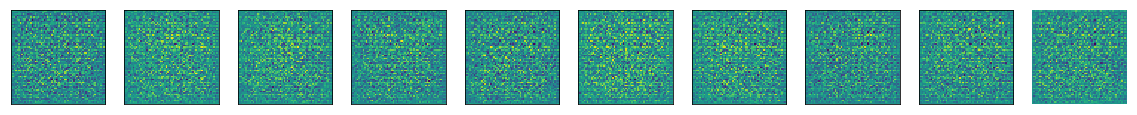

KeyboardInterrupt: 

In [13]:
train_GAN(50)